In [65]:
from pathlib import Path
import os
import torch
import time
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import matplotlib.pyplot as plt
import copy
# Téléchargement des données

from datamaestro import prepare_dataset
ds = prepare_dataset("com.lecun.mnist");


train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()

# Tensorboard : rappel, lancer dans une console tensorboard --logdir runs
#writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Pour visualiser
# Les images doivent etre en format Channel (3) x Hauteur x Largeur
images = torch.tensor(train_images[0:8]).unsqueeze(1).repeat(1,3,1,1).double()/255.
# Permet de fabriquer une grille d'images
images = make_grid(images)
# Affichage avec tensorboard
#writer.add_image(f'samples', images, 0)


savepath = Path("model.pch")

In [2]:
len(test_labels)

10000

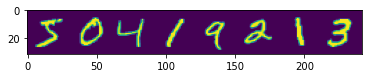

In [3]:
plt.imshow(images[0])

# Dataset + Dataloader

In [4]:
class MonDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data.reshape((data.shape[0], data.shape[1]*data.shape[2])), dtype=torch.float)
        self.target = torch.tensor(target, dtype=torch.float)

    def __getitem__(self, index):
        return (self.data[index], self.target[index])

    def __len__(self):
        return len(self.data)
    
    
BATCH_SIZE = 100    
train_loader = DataLoader(MonDataset(train_images, train_labels), shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(MonDataset(test_images, test_labels), shuffle=True, batch_size=BATCH_SIZE)

# Autoencoder + training

In [21]:
# tied autoencoder using off the shelf nn modules
class TiedAutoEncoderOffTheShelf(nn.Module):
    def __init__(self, inp, out, weight):
        super().__init__()
        self.encoder = nn.Linear(inp, out, bias=False)
        self.decoder = nn.Linear(out, inp, bias=False)

        # tie the weights
        self.encoder.weight.data = weight.clone()
        self.decoder.weight = self.encoder.weight.transpose(0,1)

    def forward(self, input):
        encoded_feats = self.encoder(input)
        reconstructed_output = self.decoder(encoded_feats)
        return encoded_feats, reconstructed_output

# tied auto encoder using functional calls
class TiedAutoEncoderFunctional(nn.Module):
    def __init__(self, inp, out1, out2):
        super().__init__()
        self.param_1 = nn.Parameter(torch.randn(out1, inp))
        self.param_2 = nn.Parameter(torch.randn(out2, out1))
        self.relu = nn.ReLU()

    def forward(self, input):
        # encodeur
        encoded_feats = F.linear(input, self.param_1)
        encoded_feats = self.relu(encoded_feats)
        encoded_feats = F.linear(encoded_feats, self.param_2)
        encoded_feats = self.relu(encoded_feats)
        # decodeur
        reconstructed_output = F.linear(encoded_feats, self.param_2.t())
        reconstructed_output = self.relu(reconstructed_output)
        reconstructed_output = F.linear(reconstructed_output, self.param_1.t())
        reconstructed_output = self.relu(reconstructed_output)

        return reconstructed_output




# mixed approach
class MixedAppraochTiedAutoEncoder(nn.Module):
    def __init__(self, inp, out1, out2 = None, out3 = None):
        super().__init__()
        self.layers = 1
        self.encoder_1 = nn.Linear(inp, out1, bias=True)
        if out2 != None:
            self.layers += 1
            self.encoder_2 = nn.Linear(out1, out2, bias=True)
        if out3 != None:
            self.layers += 1
            self.encoder_3 = nn.Linear(out2, out3, bias=True)
        #self.encoder.weight.data = weight.clone()
        self.act = nn.ReLU()

    def encoder(self,input):
        encoded_feats = self.encoder_1(input)
        x = self.act(encoded_feats)
        if self.layers > 1:
            x = self.encoder_2(x)
            x = self.act(x)
        if self.layers > 2:
            x = self.encoder_3(x)
            x = self.act(x)
        return x

    def decoder(self, x):
        if self.layers > 2:
            x = F.linear(x, self.encoder_3.weight.t())
            x = self.act(x)
        if self.layers > 1:
            x = F.linear(x, self.encoder_2.weight.t())
            x = self.act(x)
        x = F.linear(x, self.encoder_1.weight.t())
        reconstructed_output = self.act(x)
        return  reconstructed_output

    def forward(self, input):
        encoded_feats = self.encoder(input)
        reconstructed_output = self.decoder(encoded_feats)

        return  reconstructed_output

In [22]:
writer = SummaryWriter()

# Autoencodeur
n1 = 28*28
n2 = 128
n3 = 25
n4 = 5
epsilon = 1e-3
num_epochs = 10

model_0 = torch.nn.Sequential(
          torch.nn.Linear(n1,n2, bias=True),
          torch.nn.ReLU(),
          #torch.nn.Linear(n2,n3, bias=True),
          #torch.nn.ReLU(),
          #torch.nn.Linear(n3, n2, bias=True),
          #torch.nn.ReLU(),
          torch.nn.Linear(n2, n1, bias=True),
          torch.nn.ReLU(),
        )

model_1 = TiedAutoEncoderFunctional(n1,n2,n3)

model_2 = MixedAppraochTiedAutoEncoder(n1,n2,n3,n4)

model = model_2 # choose model

optimizer = torch.optim.Adam(params=model.parameters(),lr=epsilon)
optimizer.zero_grad()

error = torch.nn.MSELoss()

# Training loop
print("Training ...")

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(images)
        train_loss = error(outputs, images)
        
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss/train', train_loss, epoch)

    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images)
        test_loss = error(outputs, images)
        
        writer.add_scalar('Loss/test', test_loss, epoch)
  #if(epoch%10==0):
    print(f"Itérations {epoch}: train loss {train_loss}, test loss {test_loss}")
    train_loss_list.append(train_loss); test_loss_list.append(test_loss)
        
writer.close()

Training ...
Itérations 0: train loss 2893.158447265625, test loss 2771.692626953125
Itérations 1: train loss 2426.461669921875, test loss 2443.741943359375
Itérations 2: train loss 2459.6748046875, test loss 2330.98193359375
Itérations 3: train loss 2375.135986328125, test loss 2317.27294921875
Itérations 4: train loss 2040.0762939453125, test loss 2172.589111328125
Itérations 5: train loss 2444.396240234375, test loss 2047.4842529296875
Itérations 6: train loss 2115.638427734375, test loss 2189.888427734375
Itérations 7: train loss 1913.6142578125, test loss 1973.575927734375
Itérations 8: train loss 1948.2254638671875, test loss 1950.406494140625
Itérations 9: train loss 1740.205078125, test loss 2037.69189453125


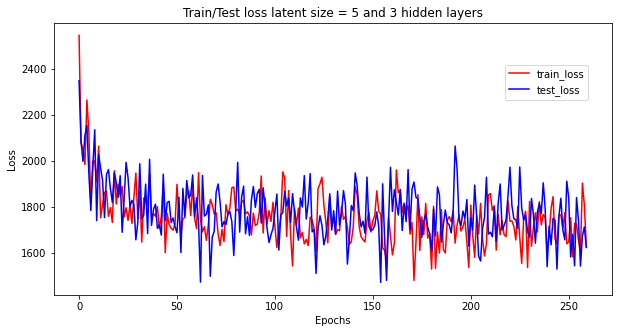

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

x = np.arange(len(train_loss_list))

a, = ax.plot(x, train_loss_list,color="red", label="train_loss")
b, = ax.plot(x, test_loss_list,color="blue", label="test_loss")
ax.set(xlabel='Epochs',ylabel='Loss')
ax.set_title(f"Train/Test loss latent size = 5 and 3 hidden layers")

plt.figlegend((a,b),("train_loss","test_loss"), loc=(0.8, 0.7))

# Results

## Data reconstruction

<ipython-input-11-e5a886d121ab>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


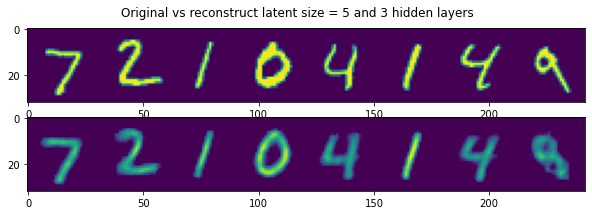

In [11]:
nb1,nb2 = 0,8
TEST = True
with torch.no_grad():
    if TEST == True:
        data = test_images  
    else:
        data = train_images
    out = model(torch.tensor(data[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
  
    images1 = torch.tensor(data[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    
    writer.add_image(f'samples', images1, 0)
    writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(2,figsize=(10,3))
    fig.suptitle('Original vs reconstruct latent size = 5 and 3 hidden layers')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])

## Data generation

<ipython-input-12-c0f61a8d4f85>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
<ipython-input-12-c0f61a8d4f85>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


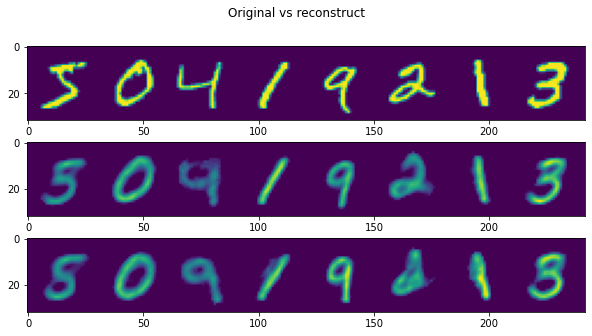

In [12]:
with torch.no_grad():
    nb1,nb2 = 0,8
  
    out = model(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features = model.encoder(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features_1 = encode_features + torch.rand(encode_features.size(0), encode_features.size(1))
    encode_features_2 = encode_features + 1000*torch.rand(encode_features.size(0), encode_features.size(1))
    decode_features_1 = model.decoder(encode_features_1)
    decode_features_2 = model.decoder(encode_features_2)

    images1 = torch.tensor(train_images[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    images3 = make_grid(images3)
    #writer.add_image(f'samples', images1, 0)
    #writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(3,figsize=(10,5))
    fig.suptitle('Original vs reconstruct')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])
    axs[2].imshow(images3[i])

## Higway Network

In [25]:
class higwayModule(nn.Module):
    
    def __init__(self, inputDim, outputDim, bias=True):
        super(Net, self).__init__()
        
        # Transform gate
        self.linear1 = nn.Linear(inputDim, outputDim, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        # Normal layer
        self.linear2 = nn.Linear(inputDim, outputDim, bias)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        T = self.sigmoid(self.linear1(x))
        C = 1.0 - T
        H = self.relu(self.linear2(x))
        
        return T*H+x*C

In [26]:
def higwayFonction(x, W, W_t):
    T = F.sigmoid(F.Linear(x, W_t.t()))
    C = 1.0 - T
    H = F.ReLU(F.Linear(x, W.t()))
    return T*H+x*C

In [27]:
# mixed approach
class MixedAppraochTiedHighWayAutoEncoder(nn.Module):
    def __init__(self, inp, out1, out2 = None, out3 = None):
        super().__init__()
        self.layers = 1
        self.encoder_1 = higwayModule(inp, out1, bias=True)
        if out2 != None:
            self.layers += 1
            self.encoder_2 = higwayModule(out1, out2, bias=True)
        if out3 != None:
            self.layers += 1
            self.encoder_3 = higwayModule(out2, out3, bias=True)
        #self.encoder.weight.data = weight.clone()
        self.act = nn.ReLU()

    def encoder(self,input):
        encoded_feats = self.encoder_1(input)
        x = self.act(encoded_feats)
        if self.layers > 1:
            x = self.encoder_2(x)
            x = self.act(x)
        if self.layers > 2:
            x = self.encoder_3(x)
            x = self.act(x)
        return x

    def decoder(self, x):
        if self.layers > 2:
            x = higwayFonction(x, self.encoder_3.linear1.weight, self.encoder_3.linear2.weight)
        if self.layers > 1:
            x = higwayFonction(x, self.encoder_2.linear1.weight, self.encoder_2.linear2.weight)
        reconstructed_output = higwayFonction(x, self.encoder_1.linear1.weight, self.encoder_1.linear2.weight)
        return  reconstructed_output

    def forward(self, input):
        encoded_feats = self.encoder(input)
        reconstructed_output = self.decoder(encoded_feats)

        return  reconstructed_output

In [28]:
writer = SummaryWriter()

# Autoencodeur
n1 = 28*28
n2 = 128
n3 = 25
n4 = 5
epsilon = 1e-3
num_epochs = 10

model_0 = torch.nn.Sequential(
          torch.nn.Linear(n1,n2, bias=True),
          torch.nn.ReLU(),
          #torch.nn.Linear(n2,n3, bias=True),
          #torch.nn.ReLU(),
          #torch.nn.Linear(n3, n2, bias=True),
          #torch.nn.ReLU(),
          torch.nn.Linear(n2, n1, bias=True),
          torch.nn.ReLU(),
        )

model_1 = TiedAutoEncoderFunctional(n1,n2,n3)

model_2 = MixedAppraochTiedAutoEncoder(n1,n2,n3,n4)

model = model_2 # choose model

optimizer = torch.optim.Adam(params=model.parameters(),lr=epsilon)
optimizer.zero_grad()

error = torch.nn.MSELoss()

# Training loop
print("Training ...")

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(images)
        train_loss = error(outputs, images)
        
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss/train', train_loss, epoch)

    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images)
        test_loss = error(outputs, images)
        
        writer.add_scalar('Loss/test', test_loss, epoch)
  #if(epoch%10==0):
    print(f"Itérations {epoch}: train loss {train_loss}, test loss {test_loss}")
    train_loss_list.append(train_loss); test_loss_list.append(test_loss)
        
writer.close()

Training ...
Itérations 0: train loss 2888.18896484375, test loss 2627.04443359375
Itérations 1: train loss 2429.80908203125, test loss 2275.341552734375
Itérations 2: train loss 2149.848876953125, test loss 2282.19140625
Itérations 3: train loss 2113.27587890625, test loss 2539.80908203125
Itérations 4: train loss 2149.071044921875, test loss 2114.777099609375
Itérations 5: train loss 2108.399169921875, test loss 2095.82275390625
Itérations 6: train loss 1992.821044921875, test loss 2025.60205078125
Itérations 7: train loss 2207.258056640625, test loss 2044.665283203125
Itérations 8: train loss 2152.8310546875, test loss 2250.125
Itérations 9: train loss 2082.724365234375, test loss 2073.60693359375


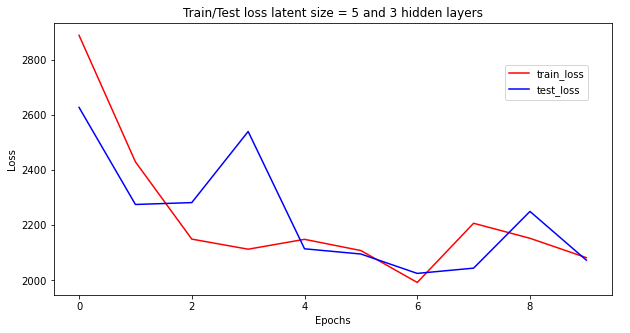

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

x = np.arange(len(train_loss_list))

a, = ax.plot(x, train_loss_list,color="red", label="train_loss")
b, = ax.plot(x, test_loss_list,color="blue", label="test_loss")
ax.set(xlabel='Epochs',ylabel='Loss')
ax.set_title(f"Train/Test loss latent size = 5 and 3 hidden layers")

plt.figlegend((a,b),("train_loss","test_loss"), loc=(0.8, 0.7))

# Results

## Data reconstruction

<ipython-input-30-e5a886d121ab>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


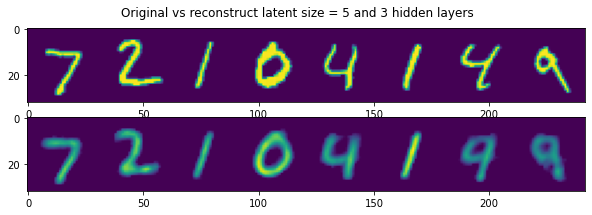

In [30]:
nb1,nb2 = 0,8
TEST = True
with torch.no_grad():
    if TEST == True:
        data = test_images  
    else:
        data = train_images
    out = model(torch.tensor(data[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
  
    images1 = torch.tensor(data[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    
    writer.add_image(f'samples', images1, 0)
    writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(2,figsize=(10,3))
    fig.suptitle('Original vs reconstruct latent size = 5 and 3 hidden layers')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])

## Data generation

<ipython-input-31-c0f61a8d4f85>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
<ipython-input-31-c0f61a8d4f85>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


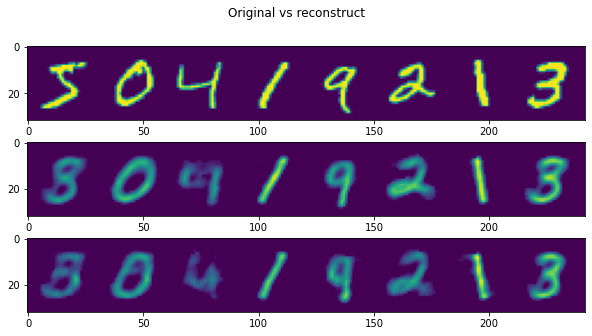

In [31]:
with torch.no_grad():
    nb1,nb2 = 0,8
  
    out = model(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features = model.encoder(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features_1 = encode_features + torch.rand(encode_features.size(0), encode_features.size(1))
    encode_features_2 = encode_features + 1000*torch.rand(encode_features.size(0), encode_features.size(1))
    decode_features_1 = model.decoder(encode_features_1)
    decode_features_2 = model.decoder(encode_features_2)

    images1 = torch.tensor(train_images[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    images3 = make_grid(images3)
    #writer.add_image(f'samples', images1, 0)
    #writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(3,figsize=(10,5))
    fig.suptitle('Original vs reconstruct')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])
    axs[2].imshow(images3[i])

## Auto encoder pour enlever le bruit 

L'entrée de l'auto encoder est simplement l'image bruité et l'image à comapré est l'image orginal (donc la seule différence est que le calcul de la loss se fait sur l'image original et l'entrée de l'auto encoder est l'image bruitée)

In [66]:
def addNoise(image, coef=0.05):
    im = copy.deepcopy(image)
    for i in range(len(im)):
        for j in range(len(im[0])):
            alea = np.random.rand()<coef
            if(alea):
                im[i][j] = 255 if alea<coef/2 else 0
                
    return im

In [67]:
writer = SummaryWriter()

# Autoencodeur
n1 = 28*28
n2 = 128
n3 = 25
n4 = 5
epsilon = 1e-3
num_epochs = 10

model_0 = torch.nn.Sequential(
          torch.nn.Linear(n1,n2, bias=True),
          torch.nn.ReLU(),
          #torch.nn.Linear(n2,n3, bias=True),
          #torch.nn.ReLU(),
          #torch.nn.Linear(n3, n2, bias=True),
          #torch.nn.ReLU(),
          torch.nn.Linear(n2, n1, bias=True),
          torch.nn.ReLU(),
        )

model_1 = TiedAutoEncoderFunctional(n1,n2,n3)

model_2 = MixedAppraochTiedAutoEncoder(n1,n2,n3,n4)

model = model_2 # choose model

optimizer = torch.optim.Adam(params=model.parameters(),lr=epsilon)
optimizer.zero_grad()

error = torch.nn.MSELoss()

# Training loop
print("Training ...")

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        im = addNoise(images)
        optimizer.zero_grad()
        outputs = model(im)
        train_loss = error(outputs, images)
        
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss/train', train_loss, epoch)

    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        with torch.no_grad():
            im = addNoise(images)
            outputs = model(im)
        test_loss = error(outputs, images)
        
        writer.add_scalar('Loss/test', test_loss, epoch)
  #if(epoch%10==0):
    print(f"Itérations {epoch}: train loss {train_loss}, test loss {test_loss}")
    train_loss_list.append(train_loss); test_loss_list.append(test_loss)
        
writer.close()

Training ...


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

x = np.arange(len(train_loss_list))

a, = ax.plot(x, train_loss_list,color="red", label="train_loss")
b, = ax.plot(x, test_loss_list,color="blue", label="test_loss")
ax.set(xlabel='Epochs',ylabel='Loss')
ax.set_title(f"Train/Test loss latent size = 5 and 3 hidden layers")

plt.figlegend((a,b),("train_loss","test_loss"), loc=(0.8, 0.7))

# Results

## Data reconstruction

<ipython-input-11-e5a886d121ab>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


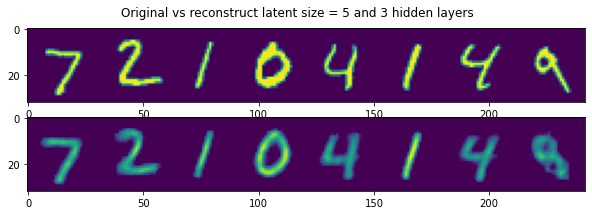

In [11]:
nb1,nb2 = 0,8
TEST = True
with torch.no_grad():
    if TEST == True:
        data = test_images  
    else:
        data = train_images
    out = model(torch.tensor(data[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
  
    images1 = torch.tensor(data[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    
    writer.add_image(f'samples', images1, 0)
    writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(2,figsize=(10,3))
    fig.suptitle('Original vs reconstruct latent size = 5 and 3 hidden layers')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])

## Data generation

<ipython-input-12-c0f61a8d4f85>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
<ipython-input-12-c0f61a8d4f85>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


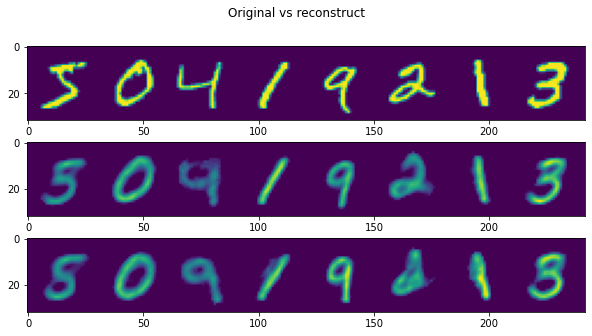

In [12]:
with torch.no_grad():
    nb1,nb2 = 0,8
  
    out = model(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features = model.encoder(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features_1 = encode_features + torch.rand(encode_features.size(0), encode_features.size(1))
    encode_features_2 = encode_features + 1000*torch.rand(encode_features.size(0), encode_features.size(1))
    decode_features_1 = model.decoder(encode_features_1)
    decode_features_2 = model.decoder(encode_features_2)

    images1 = torch.tensor(train_images[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    images3 = make_grid(images3)
    #writer.add_image(f'samples', images1, 0)
    #writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(3,figsize=(10,5))
    fig.suptitle('Original vs reconstruct')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])
    axs[2].imshow(images3[i])